# Applied exercises

### Exercise 7

In the chapter, we mentioned the use of correlation-based distance and Euclidean distance as dissimilarity measures for hierarchical clustering. It turns out that these two measures are almost equivalent: if each observation has been centered to have mean zero and standard deviation one, and if we let rij denote the correlation between the ith and jth observations, then the quantity 1−rij is proportional to the squared Euclidean distance between the ith and jth observations. On the USArrests data, show that this proportionality holds. Hint: The Euclidean distance can be calculated using the dist() function, and correlations can be calculated using the cor() function.

#### Answer

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

Let's inspect the data:

In [2]:
# Load USA arrests data
data_usarrests = pd.read_csv('../data/usa_arrest.csv')
print(data_usarrests)

                Murder  Assault  UrbanPop  Rape
Alabama           13.2      236        58  21.2
Alaska            10.0      263        48  44.5
Arizona            8.1      294        80  31.0
Arkansas           8.8      190        50  19.5
California         9.0      276        91  40.6
Colorado           7.9      204        78  38.7
Connecticut        3.3      110        77  11.1
Delaware           5.9      238        72  15.8
Florida           15.4      335        80  31.9
Georgia           17.4      211        60  25.8
Hawaii             5.3       46        83  20.2
Idaho              2.6      120        54  14.2
Illinois          10.4      249        83  24.0
Indiana            7.2      113        65  21.0
Iowa               2.2       56        57  11.3
Kansas             6.0      115        66  18.0
Kentucky           9.7      109        52  16.3
Louisiana         15.4      249        66  22.2
Maine              2.1       83        51   7.8
Maryland          11.3      300        6

In [3]:
# Define X
features = ['Murder', 'Assault', 'UrbanPop', 'Rape']
X = data_usarrests.loc[:, features].values

# Standarize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

Let's make sure we have transformed the data to have mean zero and std 1:

In [4]:
# Take mean and std of each column (feature)
mean = np.mean(X,axis=0)
print("These are the columns means: \n" + str(mean))
std = np.std(X, axis=0)
print("\nThese are the columns std: \n" + str(std))

These are the columns means: 
[-7.10542736e-17  1.38777878e-16 -4.39648318e-16  8.59312621e-16]

These are the columns std: 
[1. 1. 1. 1.]


Now we calculate the eucledian distance and the 1- corrlation values for the paiwise comparisons of each row in X:

In [5]:
euclidean = pdist(X, metric='seuclidean') # calculate squared euclidean distance
correlation = 1 - pdist(X, metric='correlation') # calculate 1 -correlation 

Then we take the ...

In [6]:
constant = correlation/euclidean
median_constant = np.median(constant)

proportion = correlation - median_constant*euclidean
median_proportion = np.median(proportion)
print('The median is: ' + str(median_proportion))

The median is: 0.0


### Exercise 8

In Section 10.2.3, a formula for calculating PVE was given in Equation 10.8. We also saw that the PVE can be obtained using the sdev output of the prcomp() function.

On the USArrests data, calculate PVE in two ways:
- (a) Using the sdev output of the prcomp() function, as was done in Section 10.2.3.
- (b) By applying Equation 10.8 directly. That is, use the prcomp() function to compute the principal component loadings. Then, use those loadings in Equation 10.8 to obtain the PVE.

These two approaches should give the same results.

Hint: You will only obtain the same results in (a) and (b) if the same data is used in both cases. For instance, if in (a) you performed prcomp() using centered and scaled variables, then you must center and scale the variables before applying Equation 10.3 in (b).

#### Answer

In [7]:
from sklearn.decomposition import PCA

Let's compute PCA over scaled data:

In [8]:
# Compute PCA
pca = PCA()
pca_data = pca.fit_transform(X)

Let's compute the proportion of variance explained by each component using the output explained_variance_ratio_ of scikit learn:

In [9]:
# Print explained variance by each component
variance_ratio = pca.explained_variance_ratio_

columns_pca = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']
variance_df = pd.DataFrame([variance_ratio], index = ['Variance_ratio'], columns=columns_pca)
print(variance_df)

                  PCA_1     PCA_2     PCA_3     PCA_4
Variance_ratio  0.62006  0.247441  0.089141  0.043358


Let's compute the PVE using Equation 10.8. 

In [10]:
# Define PCA loadings
pca_loadings = (pca.components_).T
pca_loadings_df = pd.DataFrame(pca_loadings, index=features, columns=columns_pca)

In [11]:
# Compute denominator (this is going to be the same for every pca)
matrix_sqr = X**2 
sum_denominator = np.sum(matrix_sqr)

# Compute numerator for each pca
for pca in range(0,len(columns_pca)):
    
    # import corresponding loadings
    loadings = pca_loadings[:,pca]

    # make sure to grab correct loadings (their sum of squares should approximate 1)
    assert np.sum(loadings**2) > 0.99
    
    # compute numerator
    matrix = X * loadings
    sum_pred_n = np.sum(matrix, axis=1)
    sum_pred_n_sqr = sum_pred_n ** 2
    sum_numerator = np.sum(sum_pred_n_sqr)
    
    answer = sum_numerator/sum_denominator
    print('PCA_' + str(pca) + ' PVE :' + str(answer))


PCA_0 PVE :0.6200603947873735
PCA_1 PVE :0.2474412881349605
PCA_2 PVE :0.08914079514520756
PCA_3 PVE :0.043357521932458856


There is a easier way to do this:
   

In [12]:
#######

### Exercise 9

Consider the USArrests data. We will now perform hierarchical clustering on the states.

- (a) Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states.
- (b) Cut the dendrogram at a height that results in three distinct clusters. Which states belong to which clusters?
- (c) Hierarchically cluster the states using complete linkage and Euclidean distance, after scaling the variables to have standard deviation one.
- (d) What effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should the variables be scaled before the inter-observation dissimilarities are computed? Provide a justification for your answer.

#### Answer:

Let's do hierarchical clutering with complete linkage and Euclidean distance using Scipy:

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

import matplotlib.pyplot as plt
%matplotlib inline

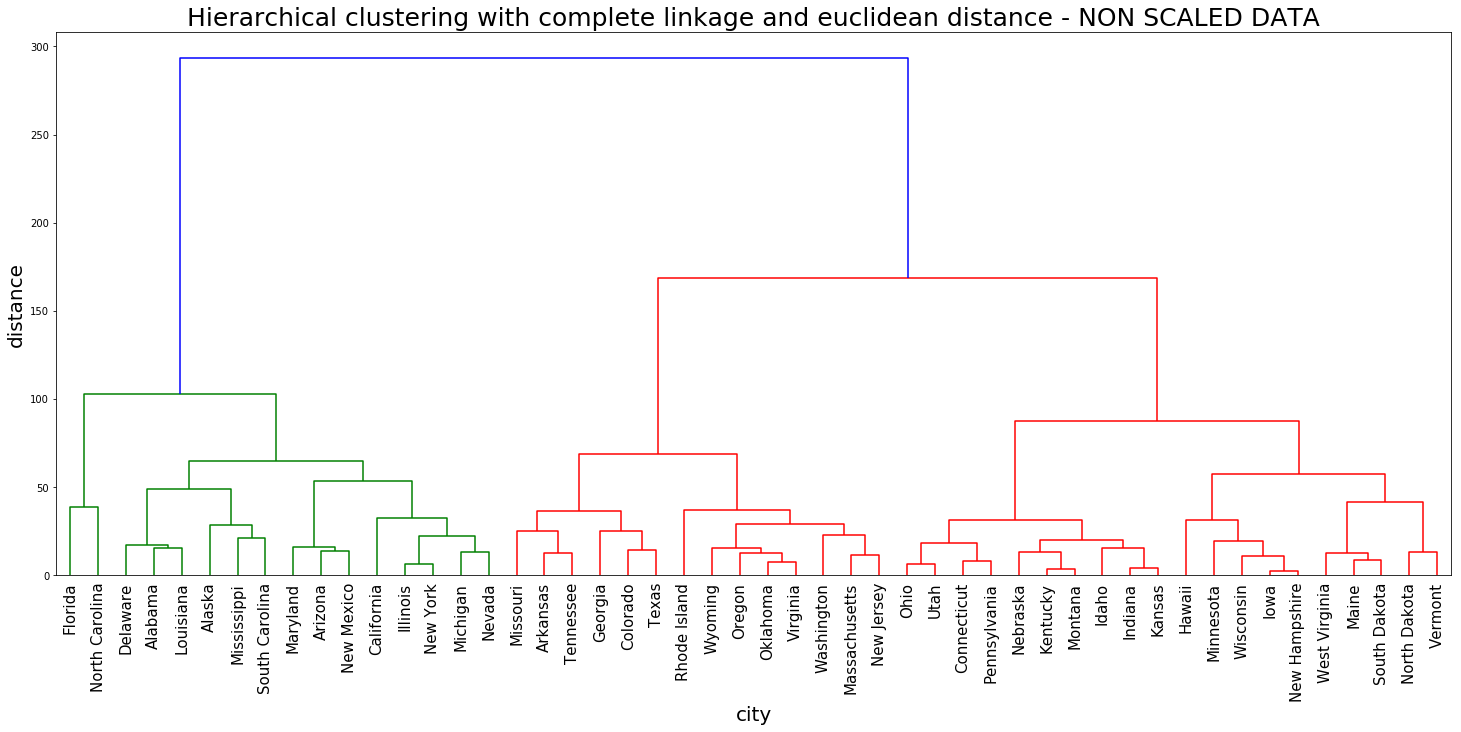

In [14]:
# Define non-scaled data
X_raw = data_usarrests.loc[:, features].values

# Perform hierarchical clustering
hc_usarrests = linkage(X_raw, method='complete', metric='euclidean')

# Plot dedrogram
states = data_usarrests.index.get_values()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical clustering with complete linkage and euclidean distance - NON SCALED DATA', size=25)
plt.xlabel('city', size=20)
plt.ylabel('distance', size=20)
dendrogram(hc_usarrests,leaf_rotation=90., leaf_font_size=15, labels=states)
plt.show()

In [15]:
# Cut tree with three clusters
clusters_3 = cut_tree(hc_usarrests, n_clusters=3)

# Display which states belong to which clusters
clusters_3_df = pd.DataFrame(clusters_3, index=states, columns=['Cluster'])
print(clusters_3_df)

                Cluster
Alabama               0
Alaska                0
Arizona               0
Arkansas              1
California            0
Colorado              1
Connecticut           2
Delaware              0
Florida               0
Georgia               1
Hawaii                2
Idaho                 2
Illinois              0
Indiana               2
Iowa                  2
Kansas                2
Kentucky              2
Louisiana             0
Maine                 2
Maryland              0
Massachusetts         1
Michigan              0
Minnesota             2
Mississippi           0
Missouri              1
Montana               2
Nebraska              2
Nevada                0
New Hampshire         2
New Jersey            1
New Mexico            0
New York              0
North Carolina        0
North Dakota          2
Ohio                  2
Oklahoma              1
Oregon                1
Pennsylvania          2
Rhode Island          1
South Carolina        0
South Dakota    

Now we repeat these steps using scaled data:

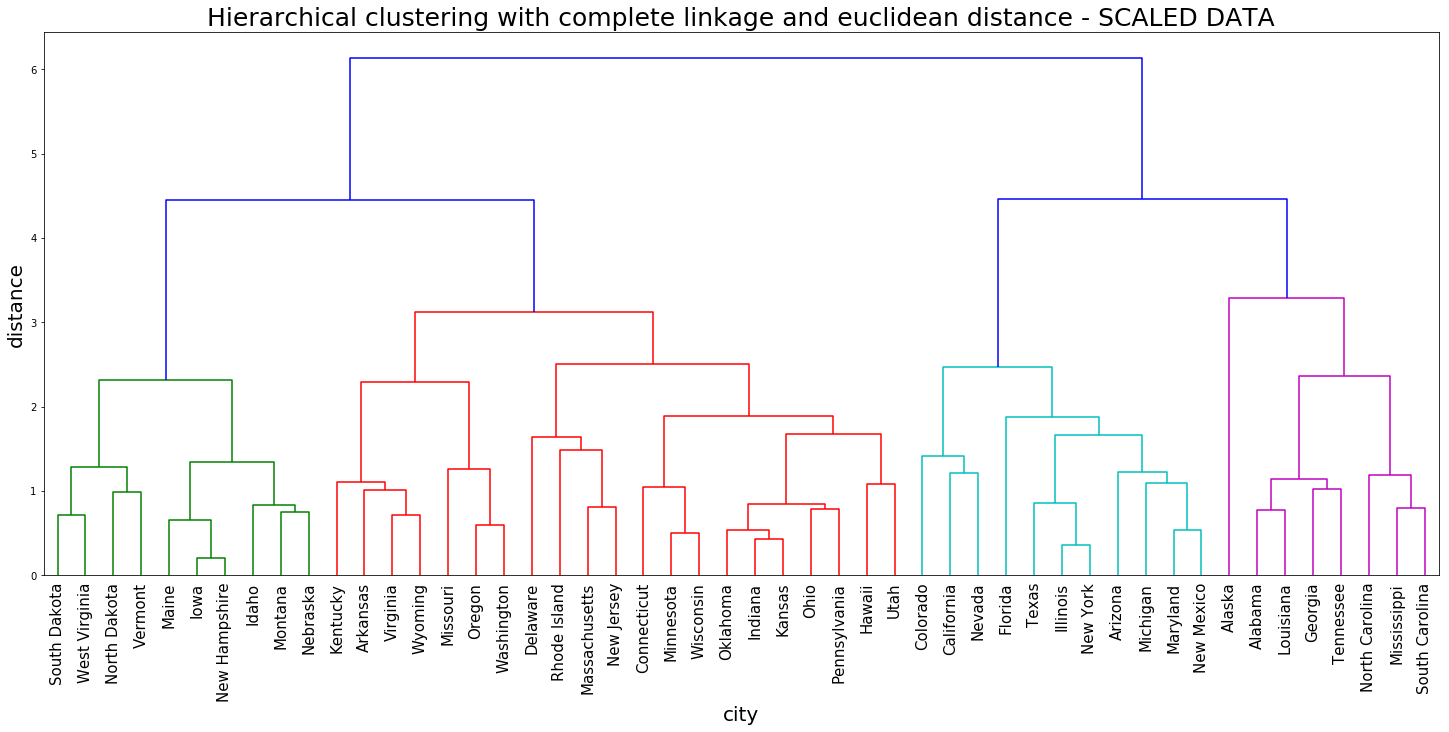

In [16]:
# Perform hierarchical clustering on scaled data
hc_usarrests_scaled = linkage(X, method='complete', metric='euclidean')

# Plot dedrogram
states = data_usarrests.index.get_values()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical clustering with complete linkage and euclidean distance - SCALED DATA', size=25)
plt.xlabel('city', size=20)
plt.ylabel('distance', size=20)
dendrogram(hc_usarrests_scaled,leaf_rotation=90., leaf_font_size=15, labels=states)
plt.show()

# Cut tree with three clusters
clusters_3_scaled = cut_tree(hc_usarrests_scaled, n_clusters=3)

In [17]:
# Display which states belong to which clusters, comparing scaled and non-scaled data
clusters = np.append(clusters_3, clusters_3_scaled, axis=1)

clusters_3_df = pd.DataFrame(clusters,
                             index = states,
                             columns = ['Non-scaled cluster', 'Scaled cluster']
                             )

print(clusters_3_df)

                Non-scaled cluster  Scaled cluster
Alabama                          0               0
Alaska                           0               0
Arizona                          0               1
Arkansas                         1               2
California                       0               1
Colorado                         1               1
Connecticut                      2               2
Delaware                         0               2
Florida                          0               1
Georgia                          1               0
Hawaii                           2               2
Idaho                            2               2
Illinois                         0               1
Indiana                          2               2
Iowa                             2               2
Kansas                           2               2
Kentucky                         2               2
Louisiana                        0               0
Maine                          

- Scaling the data affects the results a lot. Non-scaled data makes data more similar, because...
- The data have different scales, if not the choice of units with greatly affect the data 


Interpretation: 

Book says: The earlier (lower in the tree) fusions occur, the more similar the groups of observations are to each other. On the other hand, observations that fuse later (near the top of the tree) can be quite different.

Thus, observations that fuse at the very bottom of the tree are quite similar to each other, whereas observations that fuse close to the top of the tree will tend to be quite different

Rather, we draw conclusions about the similarity of two observations based on the location on the vertical axis where branches containing those two observations first are fused.

In addition to carefully selecting the dissimilarity measure used, one must
also consider whether or not the variables should be scaled to have standard
deviation one before the dissimilarity between the observations is
computed. To illustrate this point, we continue with the online shopping
example just described. Some items may be purchased more frequently than
others; for instance, a shopper might buy ten pairs of socks a year, but a
computer very rarely. High-frequency purchases like socks therefore tend
to have a much larger effect on the inter-shopper dissimilarities, and hence
on the clustering ultimately obtained, than rare purchases like computers.
This may not be desirable. If the variables are scaled to have standard deviation
one before the inter-observation dissimilarities are computed, then
each variable will in effect be given equal importance in the hierarchical
clustering performed. We might also want to scale the variables to have
standard deviation one if they are measured on different scales; otherwise,
the choice of units (e.g. centimeters versus kilometers) for a particular variable
will greatly affect the dissimilarity measure obtained. It should come
as no surprise that whether or not it is a good decision to scale the variables
before computing the dissimilarity measure depends on the application at
hand. An example is shown in Figure 10.14. 

### Exercise 10

In this problem, you will generate simulated data, and then perform PCA and K-means clustering on the data.

- (a) Generate a simulated data set with 20 observations in each of three classes (i.e. 60 observations total), and 50 variables. Hint: There are a number of functions in R that you can use to generate data. One example is the rnorm() function; runif() is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes.

- (b) Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to part (c). If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes. Do not continue to part (c) until the three classes show at least some separation in the first two principal component score vectors.

- (c) Perform K-means clustering of the observations with K = 3. How well do the clusters that you obtained in K-means clustering compare to the true class labels? Hint: You can use the table() function in R to compare the true class labels to the class labels obtained by clustering. Be careful how you interpret the results: K-means clustering will arbitrarily number the clusters, so you cannot simply check whether the true class labels and clustering labels are the same.

- (d) Perform K-means clustering with K = 2. Describe your results.

- (e) Now perform K-means clustering with K = 4, and describe your results.

- (f) Now perform K-means clustering with K = 3 on the first two principal component score vectors, rather than on the raw data. That is, perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results.

- (g) Using the scale() function, perform K-means clustering with K = 3 on the data after scaling each variable to have standard deviation one. How do these results compare to those obtained in (b)? Explain.

#### Answer

(a) Let's generate the simulated data:

In [18]:
import random

In [58]:
# Set seed to obtain the same results each time
random.seed(2)

# Create matrix of random numbers with nomal distribution
np.random.seed(2)
X_2 = np.random.rand(60,50)

# Create first class
X_2[0:20,0] = X_2[0:20,0] + 3
X_2[0:20,1] = X_2[0:20,1] - 4

# Create second class
X_2[20:40,0] = X_2[20:40,0] - 10
X_2[20:40,1] = X_2[20:40,1] - 2

# Create third class
X_2[40:60,0] = X_2[40:60,0] - 7
X_2[40:60,1] = X_2[40:60,1] + 6

# Print resulting matrix
print(np.shape(X_2))
print(X_2)

(60, 50)
[[ 3.4359949  -3.97407377  0.54966248 ...  0.77655918  0.53560417
   0.95374223]
 [ 3.54420816 -3.91790508  0.3663424  ...  0.66148133  0.17047713
   0.88165224]
 [ 3.77800816 -3.86604579  0.86891663 ...  0.03124756  0.22957403
   0.7046275 ]
 ...
 [-6.64671961  6.6650456   0.21303391 ...  0.69897959  0.46109385
   0.4308646 ]
 [-6.95694254  6.2914093   0.87812068 ...  0.74090008  0.04975847
   0.81190976]
 [-6.74165151  6.5099996   0.89081362 ...  0.68773884  0.79638825
   0.58194254]]


(b) Let's perform PCA and plot its score vectors:

In [59]:
import seaborn as sns

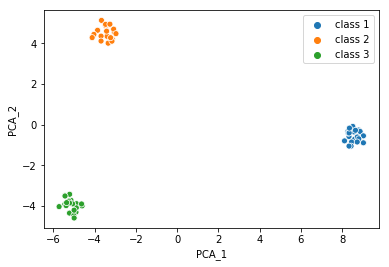

In [60]:
# Compute PCA
pca = PCA()
pca_score_vectors_2 = pca.fit_transform(X_2)

# Transform data into a dataframe
columns_pca_2 = ['PCA_' + str(pca +1) for pca in range(0, np.shape(pca_score_vectors_2)[1])]
pca_score_vectors_df_2 = pd.DataFrame(pca_score_vectors_2, columns=columns_pca_2)

# Define labels for classes
class_1 = ['class 1']* 20
class_2 = ['class 2']* 20
class_3 = ['class 3']* 20
labels = class_1 + class_2 + class_3

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], hue=labels)

(c) Let's perform K-means clustering of the observations with K = 3.

In [61]:
from sklearn.cluster import KMeans

In [62]:
# Compute k-means
kmeans = KMeans(n_clusters=3, n_init=20)
kmeans.fit(X_2)
kmeans_labels = (kmeans.labels_).tolist()

Let's compare the real class labels with those found by k-means:

In [63]:
# Create data-frame with both labels
labels_df = pd.DataFrame({'Real labels': labels, 'K-means labels': kmeans_labels})
print(labels_df)

   Real labels  K-means labels
0      class 1               1
1      class 1               1
2      class 1               1
3      class 1               1
4      class 1               1
5      class 1               1
6      class 1               1
7      class 1               1
8      class 1               1
9      class 1               1
10     class 1               1
11     class 1               1
12     class 1               1
13     class 1               1
14     class 1               1
15     class 1               1
16     class 1               1
17     class 1               1
18     class 1               1
19     class 1               1
20     class 2               2
21     class 2               2
22     class 2               2
23     class 2               2
24     class 2               2
25     class 2               2
26     class 2               2
27     class 2               2
28     class 2               2
29     class 2               2
30     class 2               2
31     c

As shown, K-means found the real clusters in the data

(d) Let's perform K-means clustering with K = 2: 

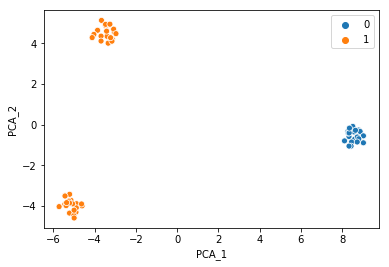

In [64]:
# Compute k-means
kmeans = KMeans(n_clusters=2, n_init=20)
kmeans.fit(X_2)
kmeans_labels = (kmeans.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], hue=kmeans_labels)

Setting k=2 produces a cluster that merges two classes. It appears two merge the two classes more similar between each other.

(e) Let's repeat the process with K=4:

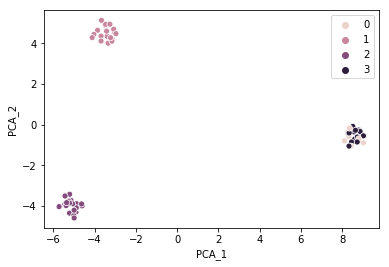

In [65]:
# Compute k-means
kmeans = KMeans(n_clusters=4, n_init=20)
kmeans.fit(X_2)
kmeans_labels = (kmeans.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], hue=kmeans_labels)

Setting k=3 produces one of classes to be divided into two clusters

(f) Let's perform K-means clustering with K = 3 on the first two principal component score vectors. So we will perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. 

Let's start by examining the pca_score vectors.

In [66]:
# Print principal component score vectors
print(pca_score_vectors_df_2)

       PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0   8.806262 -0.264602 -0.180437  0.862708 -0.163237 -0.018574 -0.102448   
1   8.878458 -0.334055 -0.489430  0.188267  0.686345 -0.362285 -0.593761   
2   9.037772 -0.549288  0.243104  0.416549  0.607623 -0.034772  0.243417   
3   8.523574 -0.087144 -0.236466  0.514329  0.438467 -0.067272 -0.633600   
4   8.610465 -0.710477  0.531189  0.791694  0.235798  0.376501  0.511937   
5   8.121099 -0.797138 -0.862601 -0.179509 -0.073895 -0.024489 -0.688403   
6   8.285449 -0.334044 -0.747281  0.019075 -0.115122 -0.116243  1.036160   
7   8.740754 -0.605663  0.658448 -0.875953 -0.171060 -0.245329  0.400721   
8   8.338009 -0.580968 -0.137982 -0.511022 -0.242367 -0.070949  0.396140   
9   8.303129 -0.416673  0.451830  0.527812  0.088743 -0.040196 -0.574642   
10  8.570349 -0.354987  1.106413  0.319607 -0.355834 -0.239951  0.259291   
11  8.345976 -0.405721  0.683384 -0.169194  0.880026  0.474375  0.071846   
12  8.651047

Let's compute k-means and plot the results:

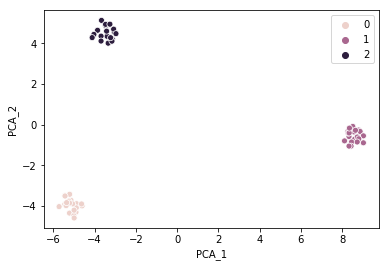

In [70]:
# Compute k-means
kmeans = KMeans(n_clusters=3, n_init=20)
kmeans.fit(pca_score_vectors_2[:,:2])
kmeans_labels = (kmeans.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], hue=kmeans_labels)

K-means can still distinguish between real classes using pca score vectors

(g) Using the scale() function, perform K-means clustering with K = 3 on the data after scaling each variable to have standard deviation one. How do these results compare to those obtained in (b)? Explain.

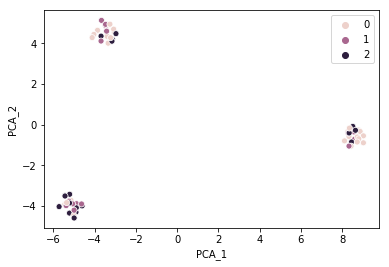

In [72]:
# Standarize data
scaler = StandardScaler()
X_2_scaled = scaler.fit_transform(X_2)

# Compute k-means
kmeans = KMeans(n_clusters=3, n_init=20)
kmeans.fit(X_2_scaled)
kmeans_labels_scaled = (kmeans.labels_).tolist()

# Plot
sns.scatterplot(pca_score_vectors_df_2.iloc[:,0], pca_score_vectors_df_2.iloc[:,1], hue=kmeans_labels_scaled)

######

### Exercise 11

On the book website, www.StatLearning.com, there is a gene expression data set (Ch10Ex11.csv) that consists of 40 tissue samples with measurements on 1,000 genes. The first 20 samples are from healthy patients, while the second 20 are from a diseased group.

- (a) Load in the data using read.csv(). You will need to select header=F.
- (b) Apply hierarchical clustering to the samples using correlation based distance, and plot the dendrogram. Do the genes separate the samples into the two groups? Do your results depend on the type of linkage used?
- (c) Your collaborator wants to know which genes differ the most across the two groups. Suggest a way to answer this question, and apply it here.

#### Answer:

(a) Let's start by loading the data:

In [138]:
# Load data
gene_data = pd.read_csv('../data/Ch10Ex11.csv', header=None) # specify that there is no column names
gene_data = gene_data.T # transpose data
print(gene_data)

# Get array of values
gene = np.arange(0,1000,1)
genes_array = gene_data.loc[:, gene].values
print(genes_array)

         0         1         2         3         4         5         6    \
0  -0.961933 -0.292526  0.258788 -1.152132  0.195783  0.030124  0.085418   
1   0.441803 -1.139267 -0.972845 -2.213168  0.593306 -0.691014 -1.113054   
2  -0.975005  0.195837  0.588486 -0.861525  0.282992 -0.403426 -0.677969   
3   1.417504 -1.281121 -0.800258  0.630925  0.247147 -0.729859 -0.562929   
4   0.818815 -0.251439 -1.820398  0.951772  1.978668 -0.364099  0.938194   
5   0.316294  2.511997 -2.058924 -1.165724 -0.871018  1.125349  0.118809   
6  -0.024967 -0.922206 -0.064764 -0.391559 -0.989715 -1.404041 -2.192225   
7  -0.063966  0.059543  1.592124  1.063619 -1.032253 -0.806130  0.685073   
8   0.031497 -1.409645 -0.173117 -0.350009 -1.109654 -1.237924  0.262304   
9  -0.350311 -0.656712 -0.121087 -1.489058 -0.385142  0.577602 -1.229459   
10 -0.722730 -0.115765 -0.187579 -0.243219  1.650957 -0.272064 -0.488366   
11 -0.281955  0.825978 -1.500163 -0.433034 -1.744909  2.176562 -0.741054   
12  1.337515

(b) Let's apply hierarchical clustering to the samples using correlation based distance with different types of linkage, and plot the dendrogram.

Text(0.5, 1.0, 'hc single')

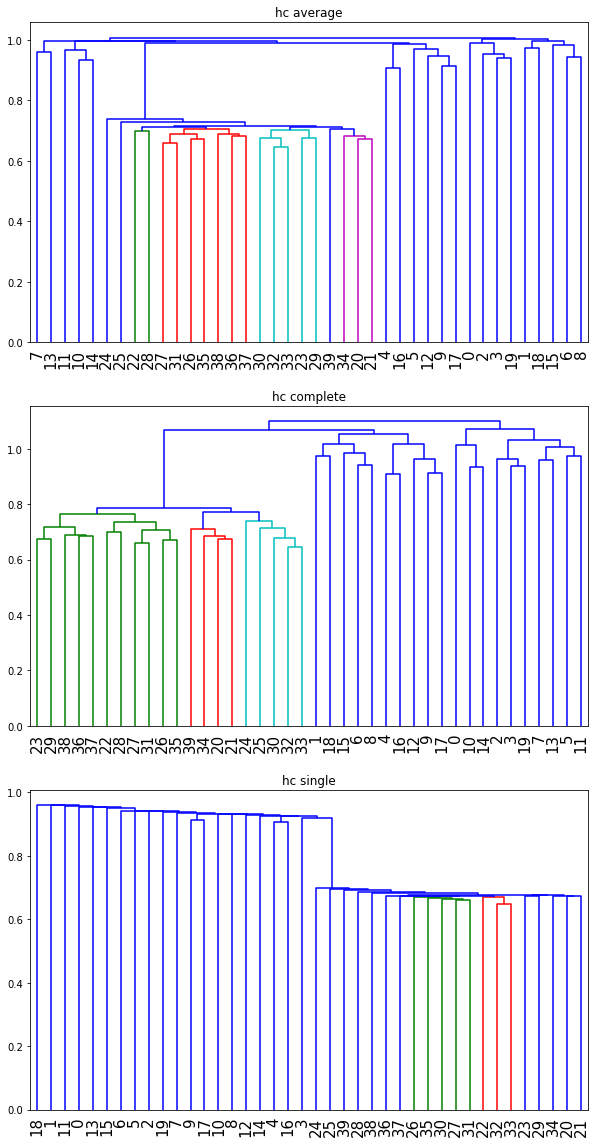

In [122]:
# Perform hierarchical clustering on scaled data
gene_hc_complete = linkage(gene_data, method='complete', metric='correlation')
gene_hc_average = linkage(gene_data, method='average', metric='correlation')
gene_hc_single = linkage(gene_data, method='single', metric='correlation')

# Plot dedrograms
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 20))

dendrogram(gene_hc_average, ax=ax1, leaf_rotation=90., leaf_font_size=15)
ax1.set_title('hc average')
dendrogram(gene_hc_complete, ax=ax2, leaf_rotation=90., leaf_font_size=15)
ax2.set_title('hc complete')
dendrogram(gene_hc_single, ax=ax3, leaf_rotation=90., leaf_font_size=15)
ax3.set_title('hc single')


In [134]:
# Cut tree with three clusters
cut_genes_complete = cut_tree(gene_hc_complete , n_clusters=2)
cut_genes_average = cut_tree(gene_hc_average , n_clusters=2)
cut_genes_single = cut_tree(gene_hc_single , n_clusters=2)

cut_all = np.hstack([cut_genes_complete, cut_genes_average, cut_genes_single])

clusters_genes = pd.DataFrame(cut_all, columns = ['Complete linkage', 'Average linkage', 'Single linkage'])
print(clusters_genes)

    Complete linkage  Average linkage  Single linkage
0                  0                0               0
1                  1                0               0
2                  0                0               0
3                  0                0               0
4                  1                1               0
5                  0                1               0
6                  1                0               0
7                  0                1               0
8                  1                0               0
9                  1                1               0
10                 0                1               0
11                 0                1               0
12                 1                1               0
13                 0                1               0
14                 0                1               0
15                 1                0               0
16                 1                1               0
17                 1        

Genes do not perfectly separate the samples into two groups, although performance improves when using complete and average linkage. 

(c) To know which genes differ the most across the two groups, we can search for the genes with the highest loadings in the first principal components analyses.

Let's start by scaling the data and performing PCA to the genes data:

In [136]:
# Scale data 
scaler = StandardScaler()
gene_scaled = scaler.fit_transform(gene_data)

# Compute PCA
pca = PCA()
pca_genes = pca.fit_transform(gene_scaled)
print(pca_genes)

[[ 8.47405343e+00  4.44189490e+00  2.87152639e+00 ...  1.77866590e-01
   3.44915900e+00  3.97714366e-15]
 [ 8.62132673e+00  6.36661253e+00  2.10332417e+00 ...  1.37009543e+00
  -1.81925156e+00  3.97714366e-15]
 [ 9.66918428e+00  1.31198468e+00  3.29412837e-01 ... -2.40661242e+00
  -5.32048573e+00  3.97714366e-15]
 ...
 [-1.01796734e+01  2.68693874e+00 -2.43416309e+00 ... -1.81795664e-01
   3.91278163e-01  3.97714366e-15]
 [-9.03657387e+00 -8.40600007e-02  6.66929785e-01 ... -3.40223077e+00
   2.46991012e+00  3.97714366e-15]
 [-1.00290809e+01  5.89817915e+00 -1.06688454e+00 ...  6.12853961e+00
  -4.34517301e-01  3.97714366e-15]]


In [ ]:
# define column names and list of genes 
columns_pca_genes = ['PCA_' + str(pca +1) for pca in range(0, np.shape(pca_genes)[1])]
genes = np.arange(1,1001,1)

# Get loadings
pca_loadings_genes = (pca.components_ ** 2).T
pca_loadings_df_genes = pd.DataFrame(pca_loadings_genes, index=genes, columns=columns_pca_genes)
print(pca_loadings_df_genes)

Select genes with highest values:

In [132]:
sorted_genes = pca_loadings_df_genes.sort_values(by=['PCA_1'])
print(sorted_genes)

            PCA_1         PCA_2         PCA_3         PCA_4         PCA_5  \
484  1.348333e-11  1.824242e-04  5.443020e-04  4.408929e-04  5.439339e-05   
949  3.950218e-10  9.209798e-05  2.352264e-04  1.323762e-04  5.180081e-06   
386  1.084548e-09  6.712569e-04  4.930181e-04  3.496857e-04  3.199571e-03   
352  2.773905e-09  4.851989e-06  2.233694e-03  2.558914e-04  2.249875e-03   
639  5.402089e-09  1.939593e-03  1.234807e-05  2.889789e-03  2.041598e-04   
21   8.857531e-09  1.680631e-04  3.590861e-04  2.552754e-04  1.808059e-03   
785  1.379602e-08  2.354597e-04  1.226497e-03  2.601256e-03  1.250292e-03   
976  1.955146e-08  2.917595e-03  6.819280e-04  4.132387e-04  5.725928e-04   
205  2.388569e-08  8.698800e-05  1.189106e-04  2.213840e-03  4.771179e-03   
614  2.877858e-08  3.923837e-04  1.072563e-03  1.056731e-03  8.206467e-05   
899  4.363648e-08  1.620634e-04  1.804424e-04  3.490744e-05  1.974323e-04   
748  4.607579e-08  3.029935e-05  1.849566e-03  6.010794e-04  1.401129e-05   

In [ ]:
tiro cluster analysis a ver si separa los dos grupos